# (21) corrupt analysis

**Motivation**: host = ```Any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

In [3]:
from analysis.corrupt import *

## 0 - Load trainers

In [4]:
models2load = {
    'iter-pois': dict(
        model_name='poisson_MNIST_t-32_z-[128]_<jacob|mlp>',
        fit_name='u:(8.0)-du:(7.0)_b200-ep500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,10:55)',
    ),
    'iter-gaus': dict(
        model_name='gaussian_MNIST_t-10_z-[128]_k-32_<jacob|mlp+b>',
        fit_name='b200-ep500-lr(0.002)_beta(5:0x0.5)_gr(1000)_(2024_09_08,16:11)',
    ),
    'amort-pois': dict(
        model_name='poisson_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep500-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,17:45)',
    ),
    'amort-gaus': dict(
        model_name='gaussian_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep400-lr(0.002)_beta(1:0x0.1)_gr(50)_(2024_09_17,20:20)',
    ),
}
kws = dict(
    path='Dropbox/chkpts/model_hub/chewie',
    device=device,
    shuffle=False,
    strict=True,
)
models2load = {
    k: {**d, **kws} for
    k, d in models2load.items()
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iter-pois']

In [6]:
tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(8.0, 7.0)

### sanity check

plot: ftrs, convergence

iter-pois

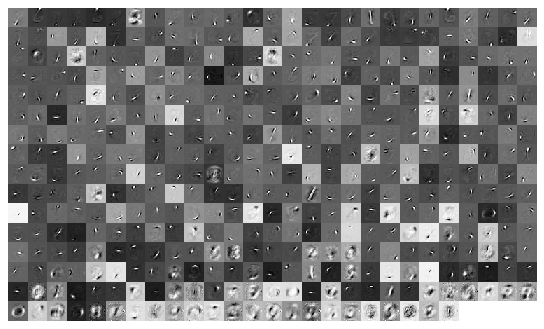

iter-gaus

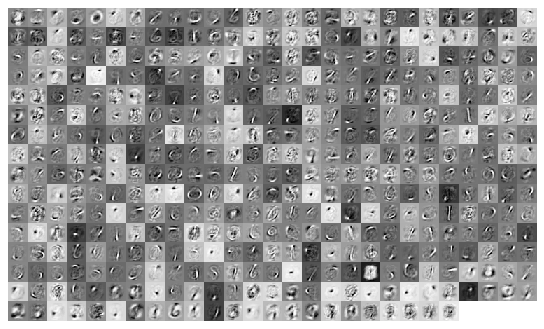

amort-pois

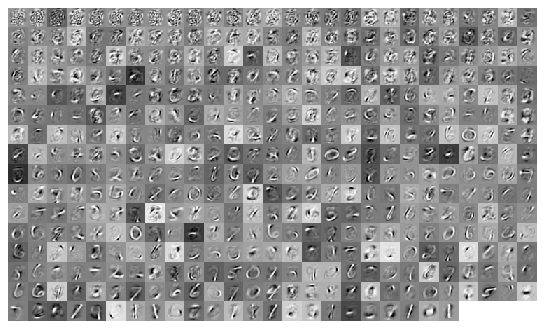

amort-gaus

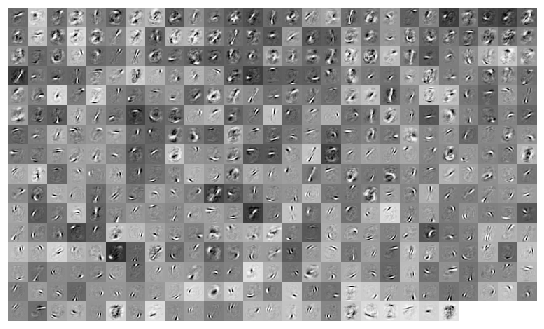

In [7]:
for name, _tr in trainers.items():
    print(name)

    w = _tr.model.layer.get_weight()
    norms = tonp(torch.linalg.vector_norm(w, dim=1))
    _tr.model.show(order=np.argsort(norms), dpi=80, pad=0)

100%|█████████████████████████████████| 50/50 [02:29<00:00,  2.99s/it]


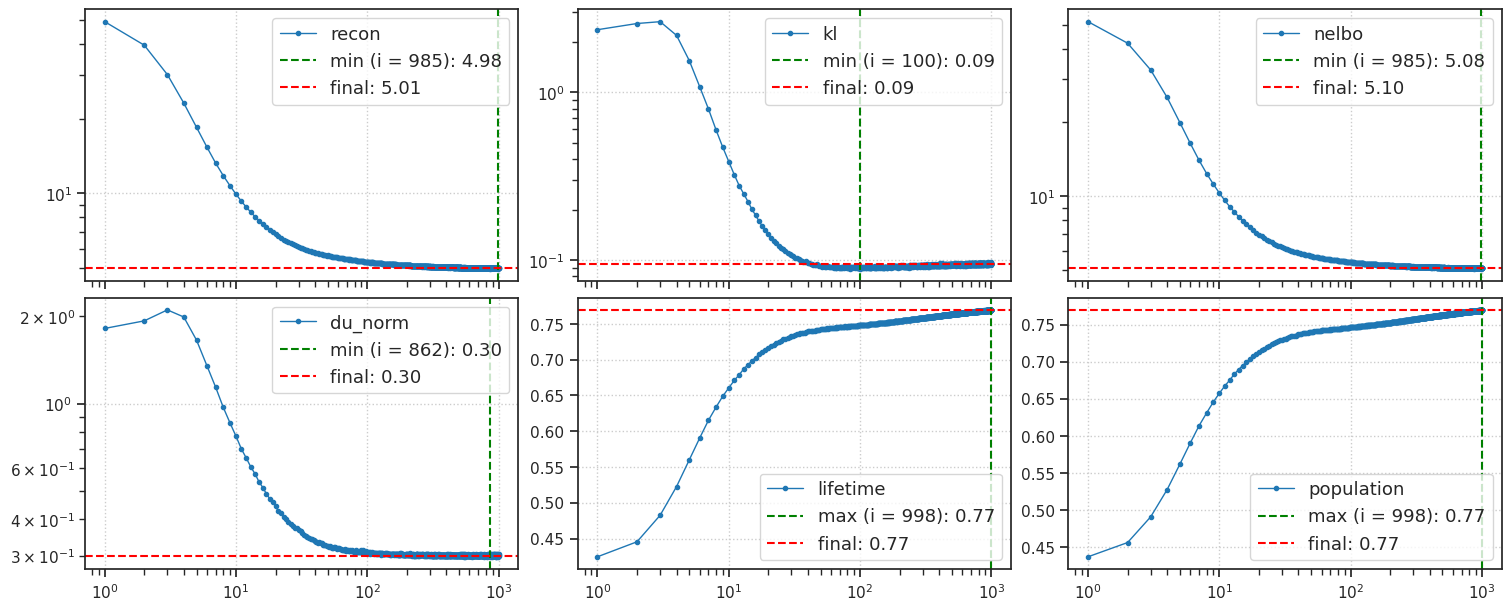

In [10]:
results = tr.analysis('vld', seq_total=1000)
_ = plot_convergence(results, color='C0')

## 1- Noise

In [11]:
sigma = 1.2

In [12]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='noise',
    corruption_kws={'sigma': sigma},
    t_recon=-1,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:20<00:00, 14.39it/s]


In [13]:
accuracy, results['mse'].mean()

(0.7425, 23.558273)

In [12]:
## Was: sigma = 0.6

(0.9015, 10.4138155)

In [14]:
list(results)

['props', 'x_corrupted', 'recon', 'state', 'mse']

In [15]:
results['x_corrupted'].shape

(10000, 784)

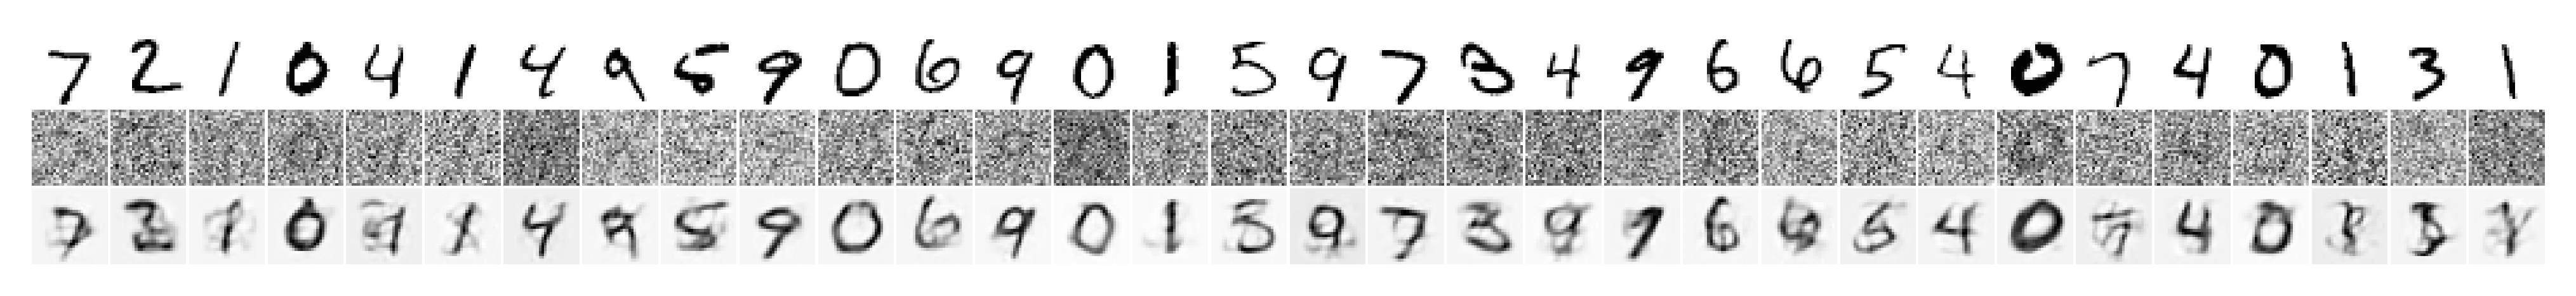

In [25]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

In [27]:
kws['tr'] = trainers['amort-pois']
results, accuracy = perform_corruption_analysis(**kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 258.09it/s]


In [28]:
accuracy, results['mse'].mean()

(0.6234, 54.358864)

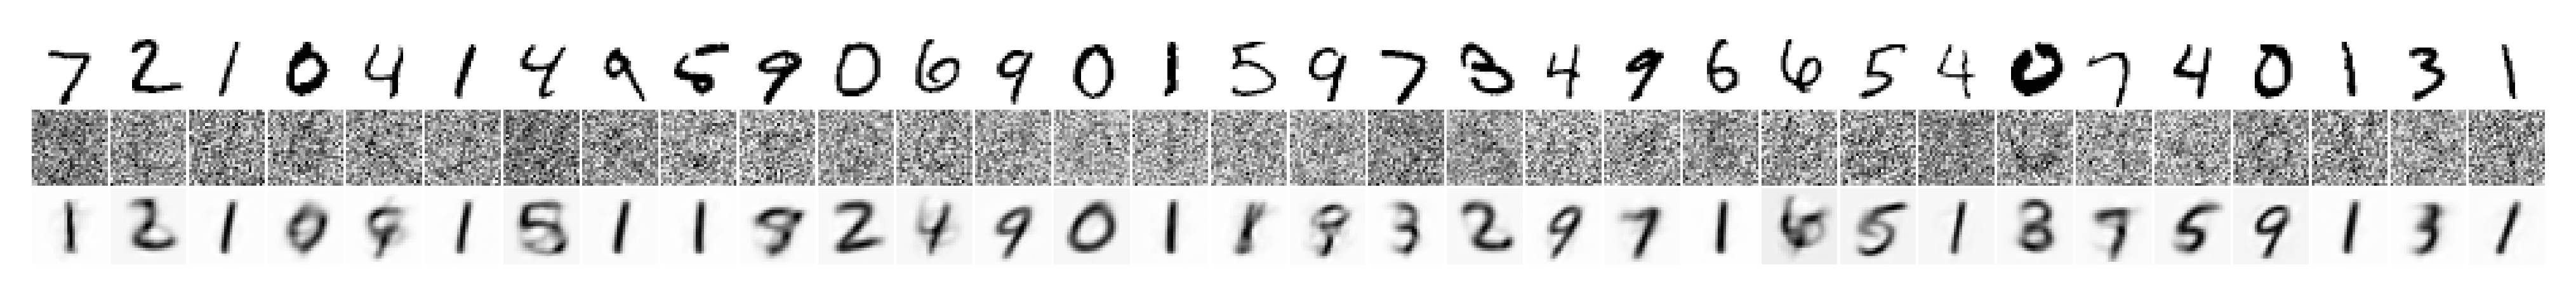

In [29]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

In [35]:
sigma = 1.2

In [36]:
kws = dict(
    tr=None,
    corruption_type='noise',
    corruption_kws={'sigma': sigma},
    t_recon=100,
    verbose=False,
)
for name, _tr in trainers.items():
    kws['tr'] = _tr
    results, accuracy = perform_corruption_analysis(**kws)
    msg = ',  '.join([
        f"mse (mean) = {np.mean(results['mse']):0.1f}",
        f"mse (median) = {np.median(results['mse']):0.1f}",
        f"accuracy = {accuracy:0.3f}",
    ])
    msg = f"{name}   ———   {msg}"
    print(msg)

iter-pois   ———   mse (mean) = 23.4,  mse (median) = 23.0,  accuracy = 0.752

iter-gaus   ———   mse (mean) = 21.8,  mse (median) = 21.4,  accuracy = 0.734

amort-pois   ———   mse (mean) = 54.7,  mse (median) = 53.2,  accuracy = 0.620

amort-gaus   ———   mse (mean) = 43.8,  mse (median) = 41.2,  accuracy = 0.670

In [37]:
kws['corruption_kws'] = {'sigma': 0.3}

for name, _tr in trainers.items():
    kws['tr'] = _tr
    results, accuracy = perform_corruption_analysis(**kws)
    msg = ',  '.join([
        f"mse (mean) = {np.mean(results['mse']):0.1f}",
        f"mse (median) = {np.median(results['mse']):0.1f}",
        f"accuracy = {accuracy:0.3f}",
    ])
    msg = f"{name}   ———   {msg}"
    print(msg)

iter-pois   ———   mse (mean) = 5.7,  mse (median) = 5.6,  accuracy = 0.938

iter-gaus   ———   mse (mean) = 9.6,  mse (median) = 9.3,  accuracy = 0.865

amort-pois   ———   mse (mean) = 25.9,  mse (median) = 24.2,  accuracy = 0.926

amort-gaus   ———   mse (mean) = 16.2,  mse (median) = 15.4,  accuracy = 0.940

## 2 - Blur

In [41]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='blur',
    corruption_kws={'sigma': 2.0, 'kernel_size': 13},
    t_recon=-1,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:21<00:00, 14.00it/s]


In [42]:
results['props']

{'sigma': 2.0, 'kernel_size': 13}

In [43]:
accuracy, results['mse'].mean()

(0.9484, 24.316904)

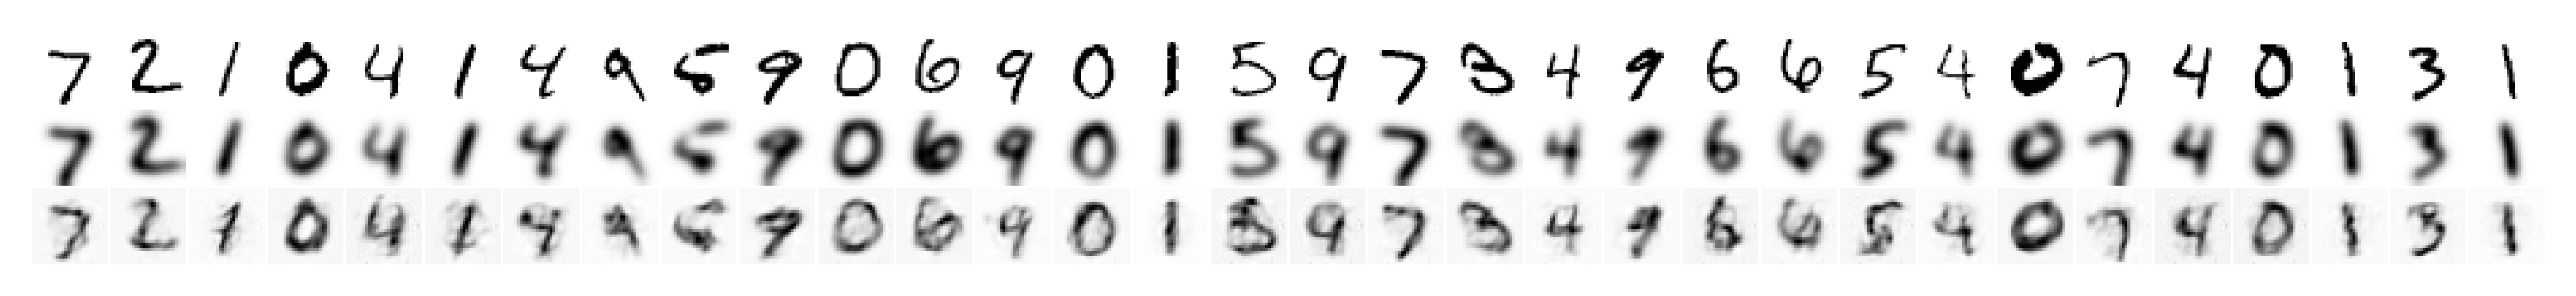

In [44]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

In [45]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='blur',
    corruption_kws={'sigma': 2.0, 'kernel_size': 13},
    t_recon=-1,
    t_halluc=-1,
    hallucinate=True,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:57<00:00,  5.23it/s]


In [46]:
accuracy, results['mse'].mean()

(0.9445, 22.620667)

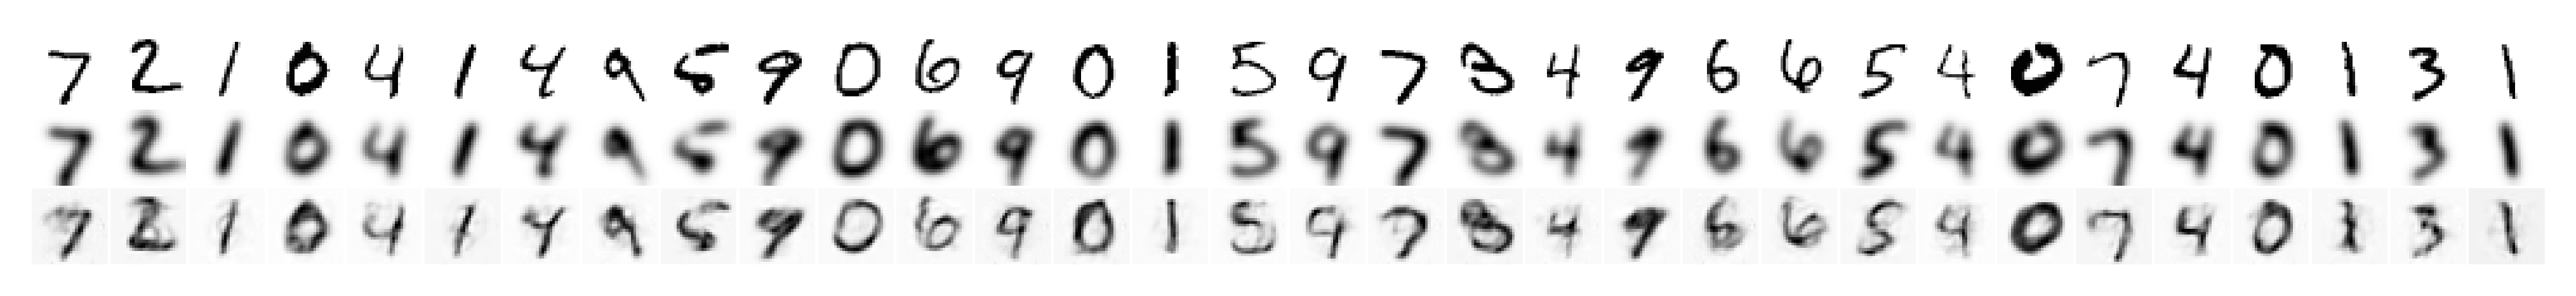

In [47]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

## 3 - Speckle

(clamped within range)

### iterative (mlp)

In [61]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='speckle',
    corruption_kws={
        'clamp': True,
        'std': 3.0},
    t_recon=300,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [05:27<00:00,  1.09s/it]


In [62]:
results_vld['props']

{'t_recon': 300,
 't_halluc': None,
 'hallucinate': False,
 'clamp': True,
 'std': 3.0,
 'mu': 0.0}

In [63]:
accuracy, results_vld['mse'].mean()

(0.9044, 15.630681)

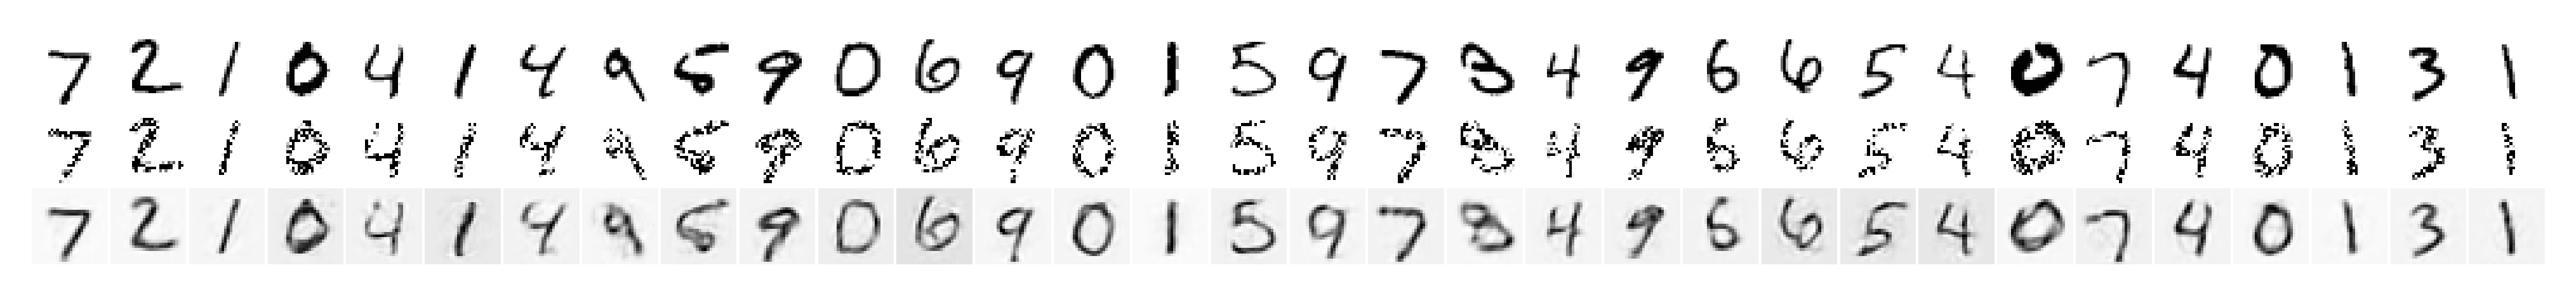

In [64]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### amortized (mlp)

In [65]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 292.27it/s]


In [66]:
results_vld['props']

{'t_recon': 1,
 't_halluc': None,
 'hallucinate': False,
 'clamp': True,
 'std': 3.0,
 'mu': 0.0}

In [67]:
accuracy, results_vld['mse'].mean()

(0.9127, 34.757553)

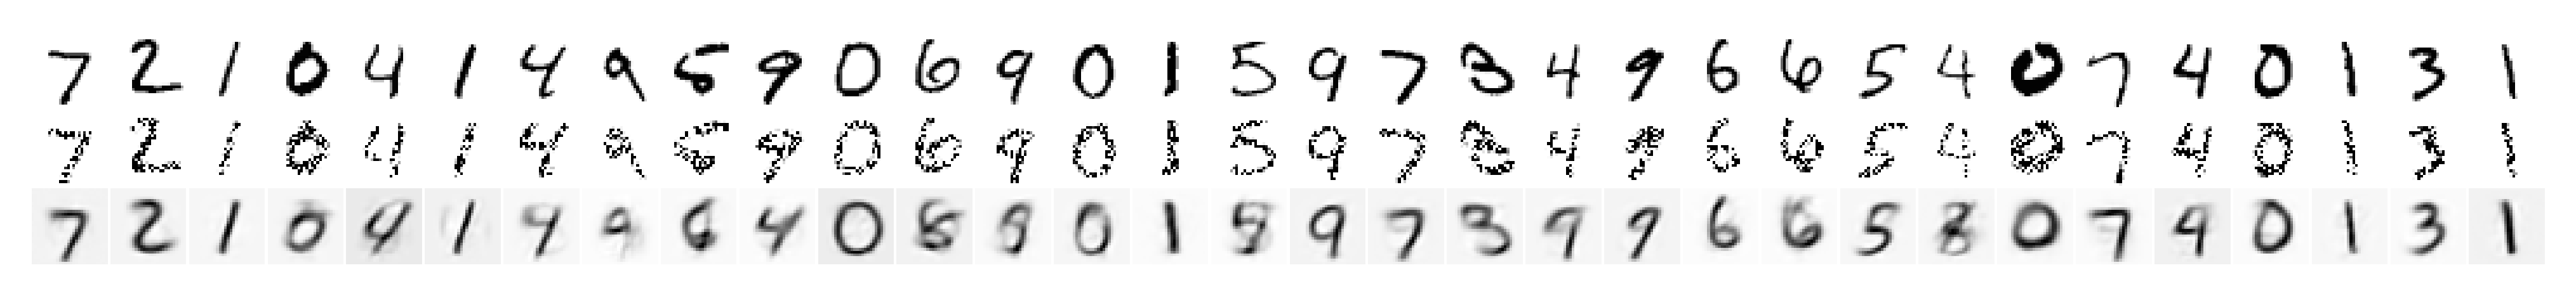

In [68]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### Speckle (not clamped)

### iterative (mlp)

In [53]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='speckle',
    corruption_kws={
        'clamp': False,
        'std': 3.0},
    t_recon=300,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [05:31<00:00,  1.11s/it]


In [54]:
results_vld['props']

{'t_recon': 300,
 't_halluc': None,
 'hallucinate': False,
 'clamp': False,
 'std': 3.0,
 'mu': 0.0}

In [55]:
accuracy, results_vld['mse'].mean()

(0.7207, 28.693016)

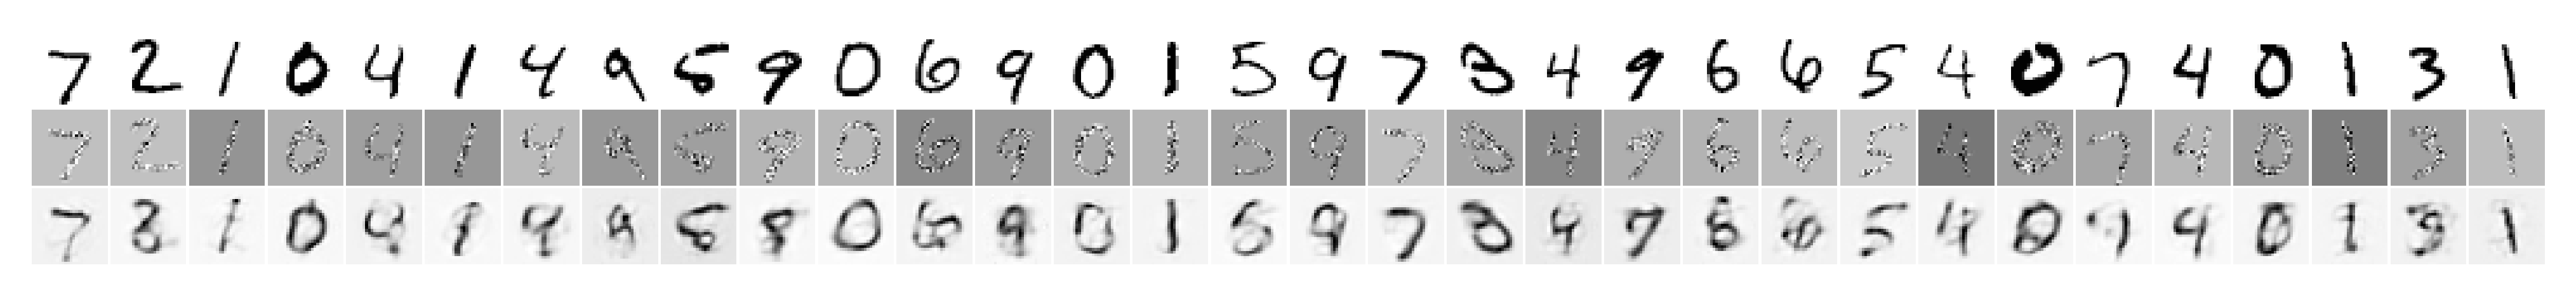

In [56]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### amortized (mlp)

In [57]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 286.94it/s]


In [58]:
results_vld['props']

{'t_recon': 1,
 't_halluc': None,
 'hallucinate': False,
 'clamp': False,
 'std': 3.0,
 'mu': 0.0}

In [59]:
accuracy, results_vld['mse'].mean()

(0.5268, 66.35009)

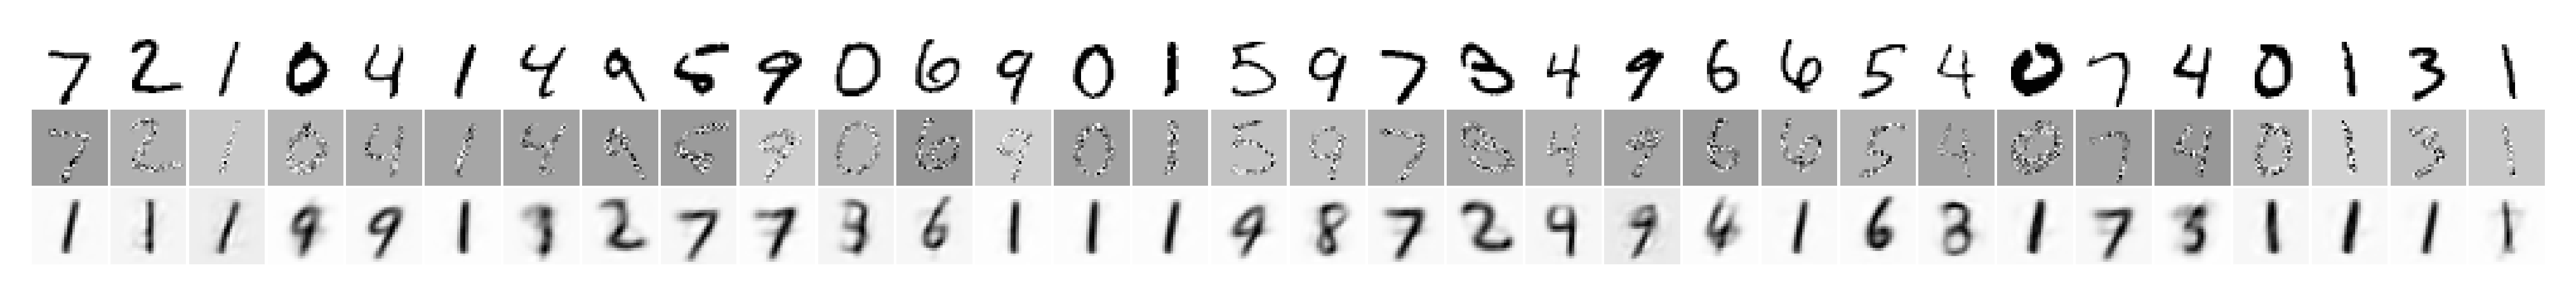

In [60]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

## 4 - Contrast

### iterative

In [13]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='contrast',
    corruption_kws={'contrast_factor': 0.3},
    t_recon=-1,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.55it/s]


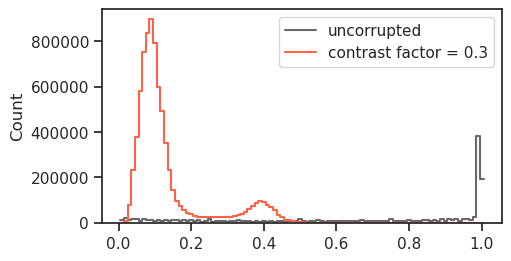

In [14]:
fig, ax = create_figure(1, 1, (5, 2.5))
bins = np.linspace(0, 1.01, 102)[1:] - 0.005
kws_fig = dict(bins=bins, stat='count', ax=ax)
histplot(tonp(tr.dl_vld.dataset.tensors[0].ravel()), color='dimgrey', label='uncorrupted', **kws_fig)
label = f"contrast factor = {results_vld['props']['contrast_factor']}"
histplot(results_vld['x_corrupted'].ravel(), color='tomato', label=label, **kws_fig)
add_legend(ax)
plt.show()

In [15]:
accuracy, results_vld['mse'].mean()

(0.9448, 6.2268205)

In [10]:
## Was: mse_wrt_orig = True

(0.9389, 29.300262)

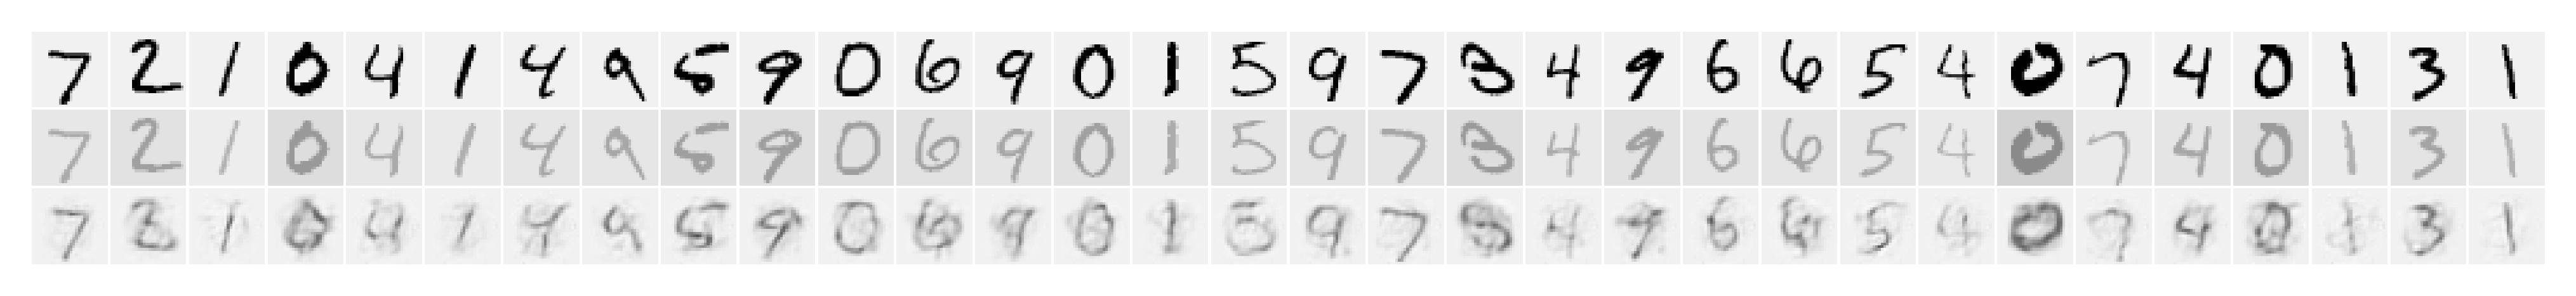

In [16]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500, method='none', vmin=0, vmax=None)

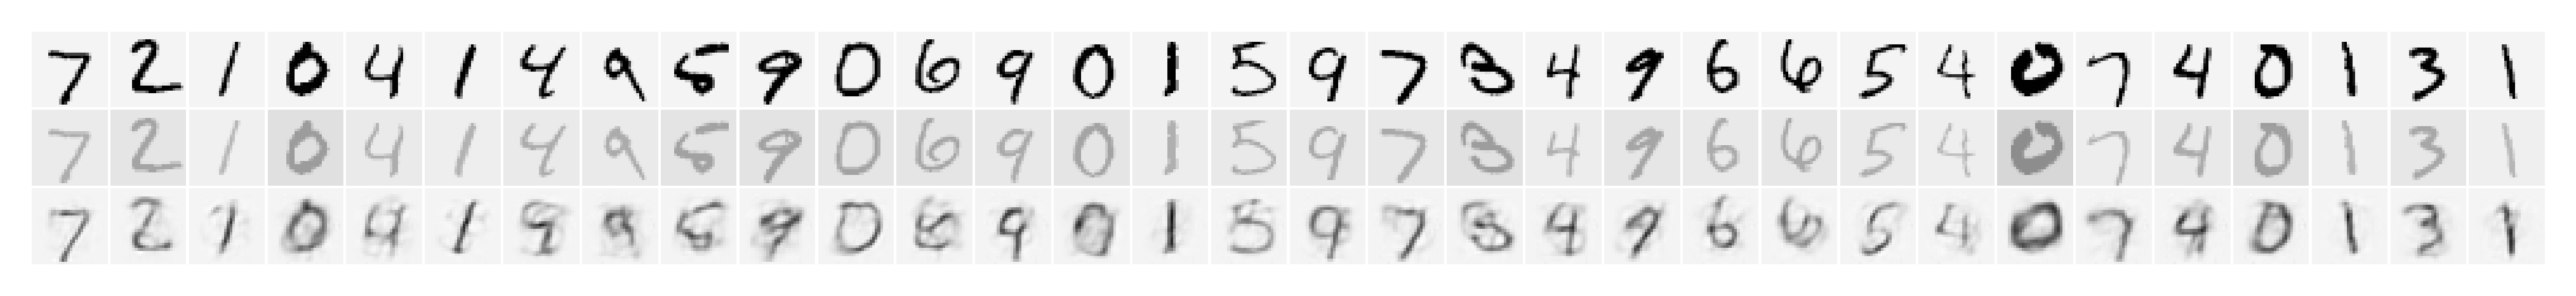

In [11]:
## Was: mse_wrt_orig = True

### amortized

In [17]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 261.10it/s]


In [18]:
accuracy, results_vld['mse'].mean()

(0.9041, 16.892859)

In [13]:
## Was: mse_wrt_orig = True

(0.9041, 55.66129)

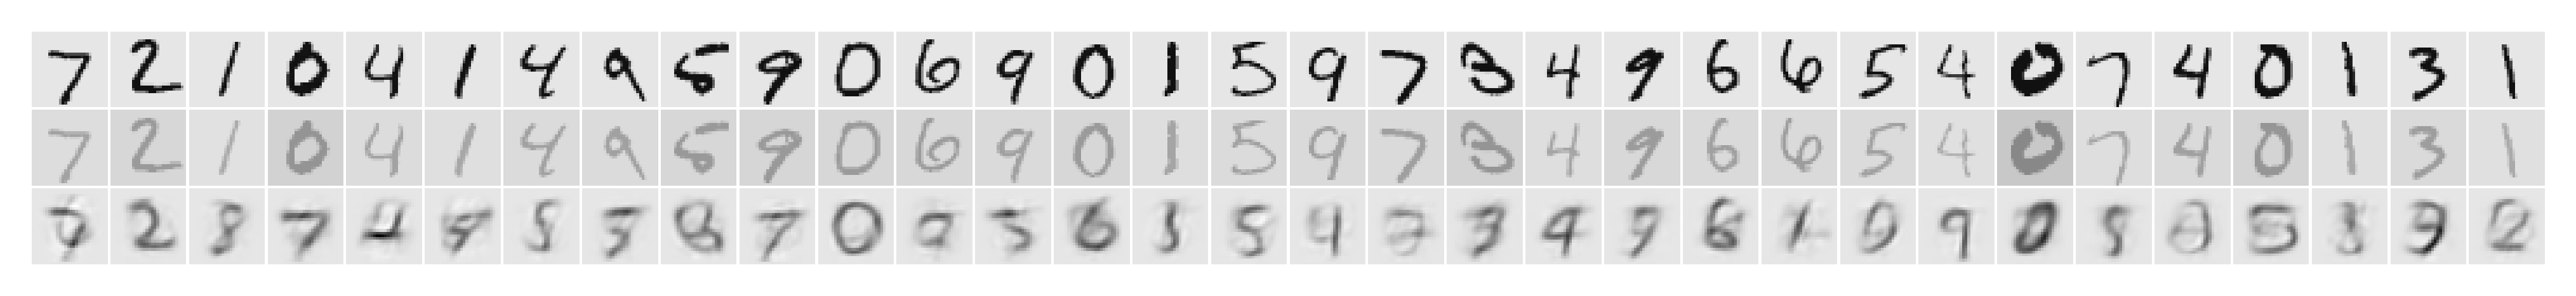

In [19]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500, method='none', vmin=0, vmax=None)

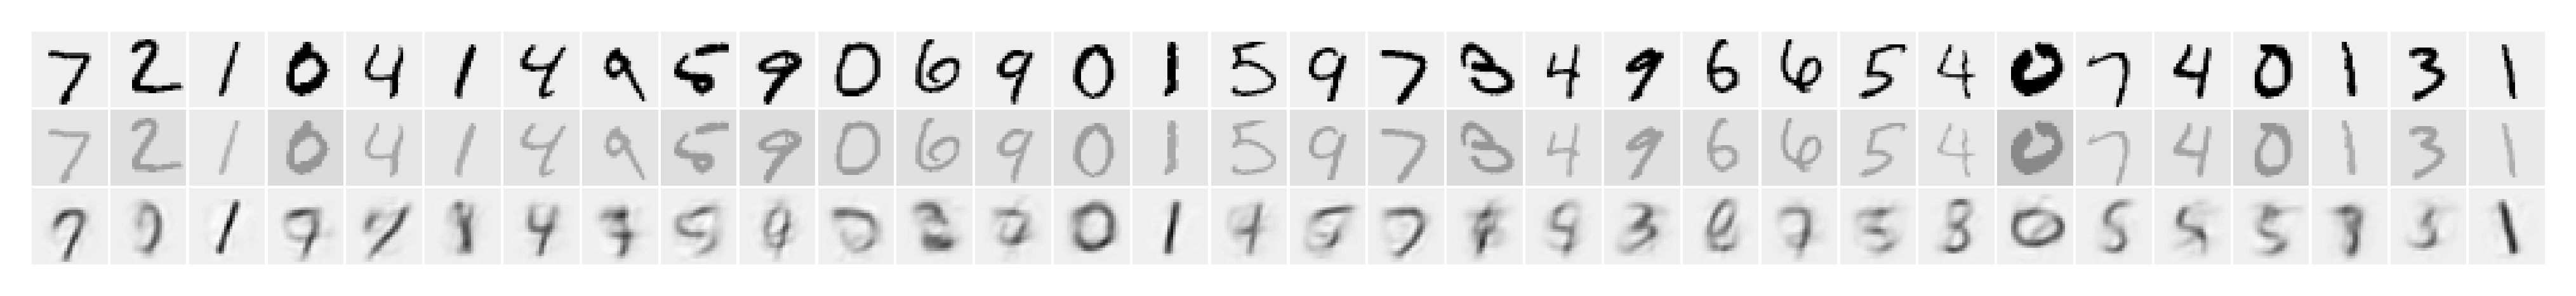

In [14]:
## Was: mse_wrt_orig = True

## 5 - Rotate

### iterative (mlp)

In [7]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='rotate',
    corruption_kws={'angle': 90},
    t_recon=120,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [02:21<00:00,  2.12it/s]


In [8]:
results_vld['props']

{'t_recon': 120,
 't_halluc': None,
 'hallucinate': False,
 'angle': 90,
 'hist_match': True,
 'interpolation': 'bilinear'}

In [9]:
accuracy, results_vld['mse'].mean()

(0.9438, 9.785647)

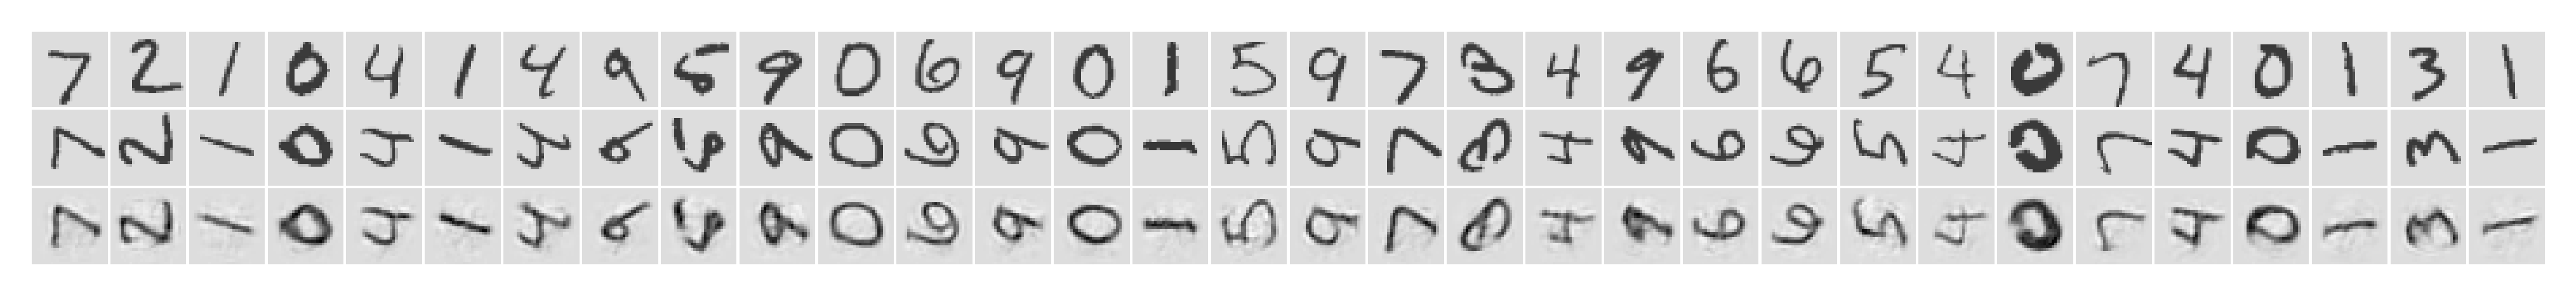

In [10]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500, method='none', vmin=0, vmax=None)

### iterative (conv)

In [11]:
tr_conv, _ = load_model(
    model_name='poisson_MNIST_t-16_z-[128]_k-32_<jacob|conv>',
    fit_name='b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:34)',
    device=device,
    shuffle=False,
    checkpoint=-1,
)

In [12]:
kws['tr'] = tr_conv
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [16:08<00:00,  3.23s/it]


In [13]:
results_vld['props']

{'t_recon': 120,
 't_halluc': None,
 'hallucinate': False,
 'angle': 90,
 'hist_match': True,
 'interpolation': 'bilinear'}

In [14]:
accuracy, results_vld['mse'].mean()

(0.9135, 5.229538)

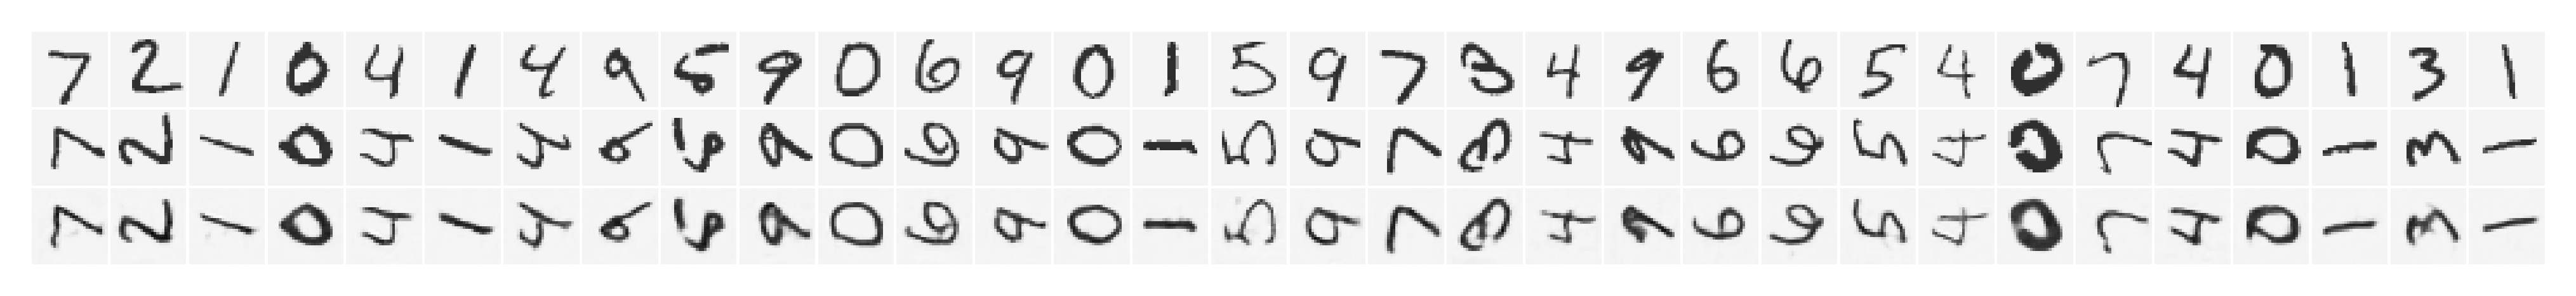

In [15]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500, method='none', vmin=0, vmax=None)

In [16]:
num = 500

output_90 = tr.model.xtract_ftr(
    tr.to(results_vld['x_corrupted'][:num]).reshape(tr.model.cfg.shape),
    seq=range(120),
).stack()

output_0 = tr.model.xtract_ftr(
    tr.dl_vld.dataset.tensors[0][:200],
    seq=range(120),
).stack()

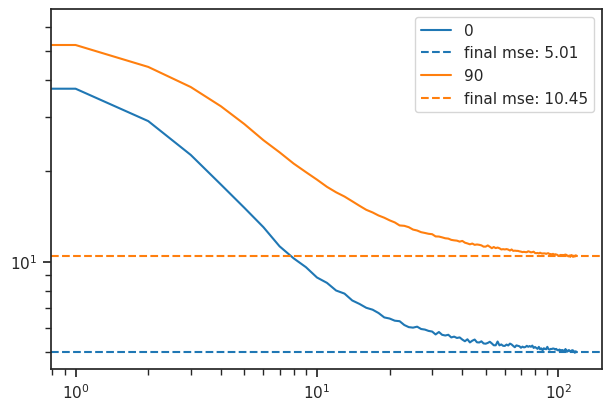

In [17]:
fig, ax = create_figure(1, 1, (6, 4))

x2p = tonp(output_0['loss_recon'].mean(0))
plt.loglog(x2p, label='0')
plt.axhline(x2p[-1], color='C0', ls='--', label=f"final mse: {x2p[-1]:0.2f}")

x2p = tonp(output_90['loss_recon'].mean(0))
plt.loglog(x2p, label='90')
plt.axhline(x2p[-1], color='C1', ls='--', label=f"final mse: {x2p[-1]:0.2f}")

plt.legend()
plt.show()

### amortized (mlp)

In [18]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:05<00:00, 55.19it/s]


In [19]:
results_vld['props']

{'t_recon': 1,
 't_halluc': None,
 'hallucinate': False,
 'angle': 90,
 'hist_match': True,
 'interpolation': 'bilinear'}

In [20]:
accuracy, results_vld['mse'].mean()

(0.8919, 48.449043)

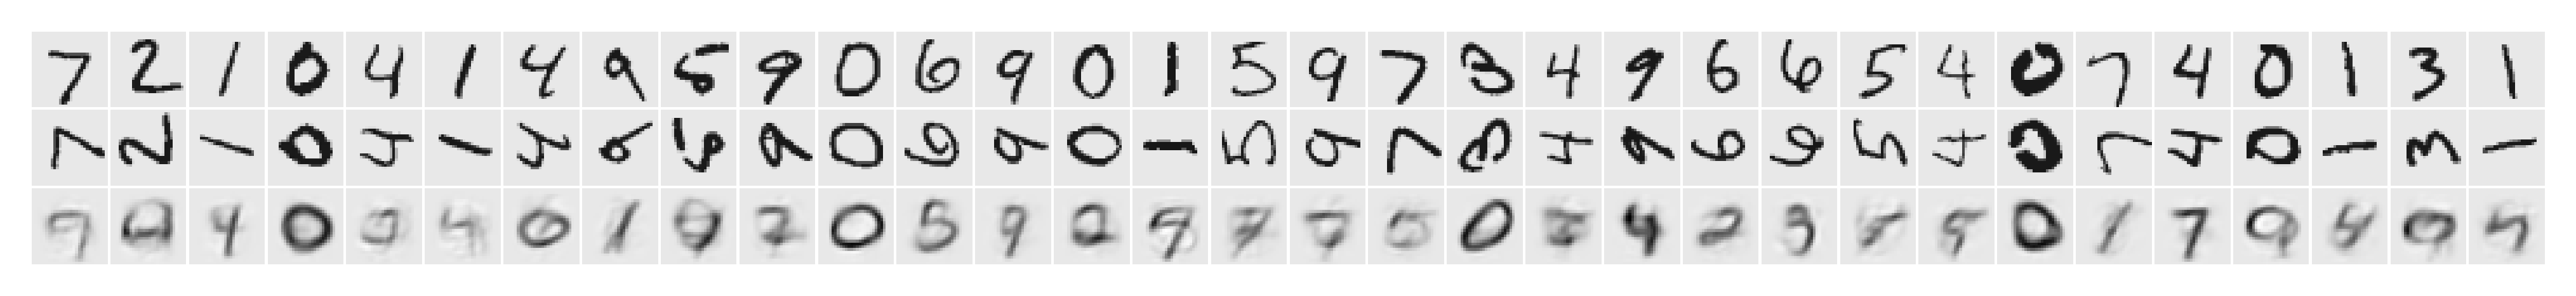

In [21]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500, method='none', vmin=0, vmax=None)

## 6 - Translate

### iterative (mlp)

In [27]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='translate',
    corruption_kws={'translate_x': 7, 'translate_y': 0},
    t_recon=-1,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:27<00:00, 11.05it/s]


In [28]:
results_vld['props']

{'t_recon': 32,
 't_halluc': None,
 'hallucinate': False,
 'translate_x': 7,
 'translate_y': 0,
 'hist_match': True,
 'interpolation': 'bilinear'}

In [29]:
accuracy, results_vld['mse'].mean()

(0.9246, 41.276287)

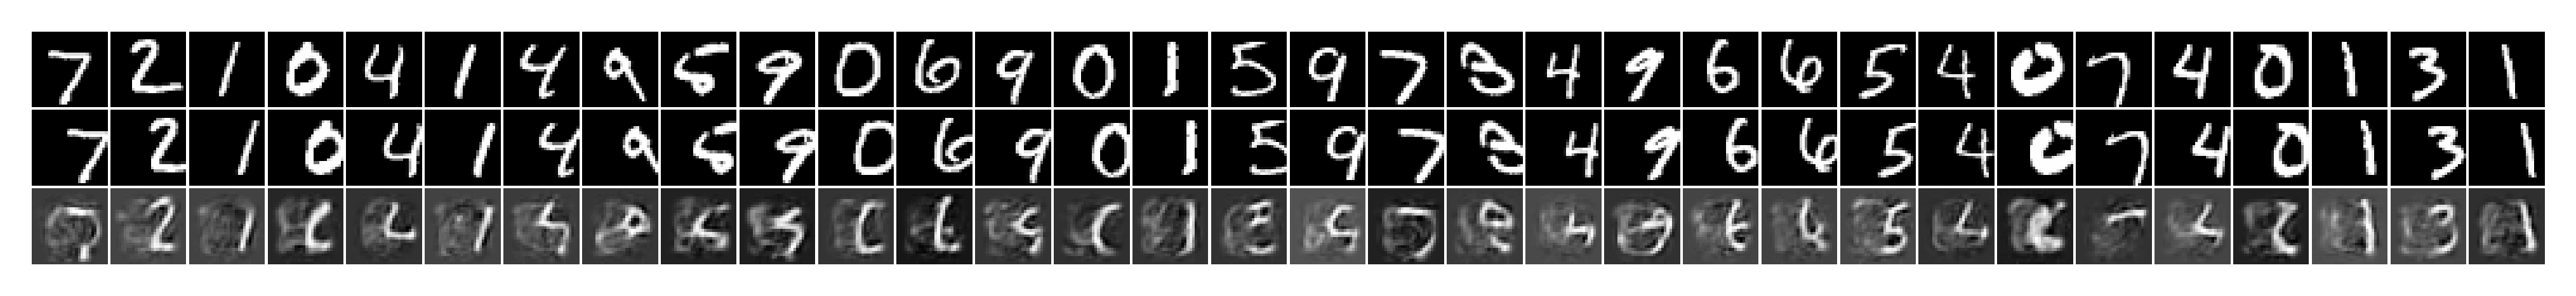

In [30]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys_r', dpi=500)

### iterative (conv)

In [31]:
tr_conv, _ = load_model(
    model_name='poisson_MNIST_t-16_z-[128]_k-32_<jacob|conv>',
    fit_name='b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:34)',
    device=device,
    shuffle=False,
    checkpoint=-1,
)

In [32]:
kws['tr'] = tr_conv
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:59<00:00,  2.52it/s]


In [33]:
results_vld['props']

{'t_recon': 16,
 't_halluc': None,
 'hallucinate': False,
 'translate_x': 7,
 'translate_y': 0,
 'hist_match': True,
 'interpolation': 'bilinear'}

In [34]:
accuracy, results_vld['mse'].mean()

(0.8943, 43.33019)

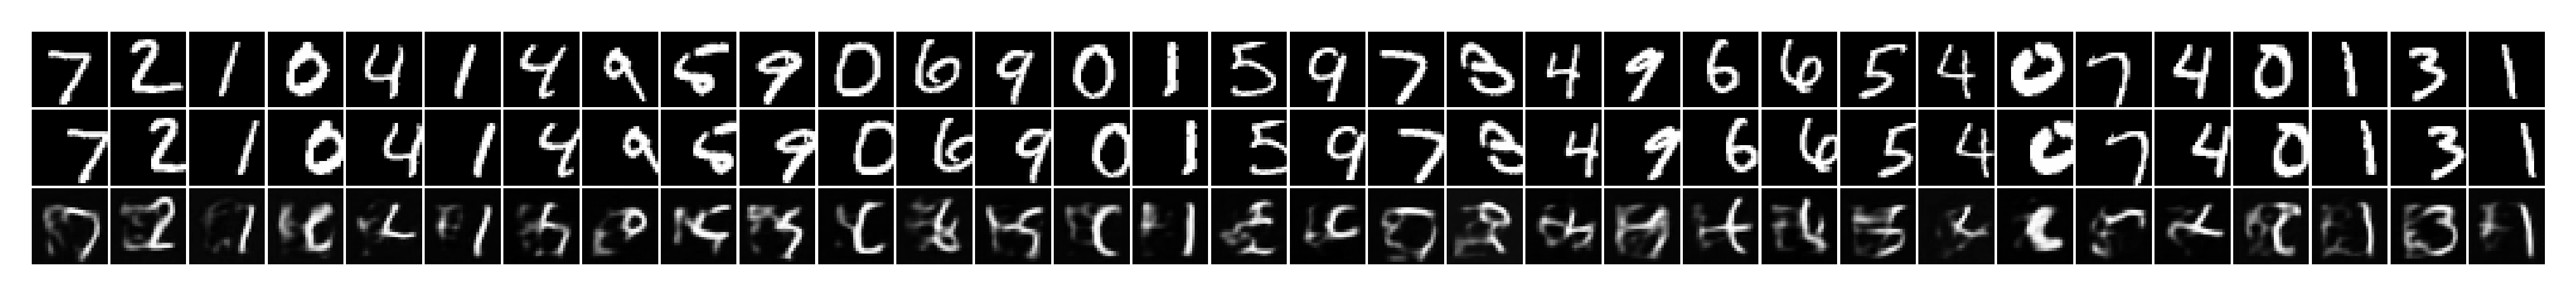

In [38]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys_r', dpi=500)

In [39]:
num = 500

output_corrupted = tr.model.xtract_ftr(
    tr.to(results_vld['x_corrupted'][:num]).reshape(tr.model.cfg.shape),
    seq=range(120),
).stack()

output_true = tr.model.xtract_ftr(
    tr.dl_vld.dataset.tensors[0][:200],
    seq=range(120),
).stack()

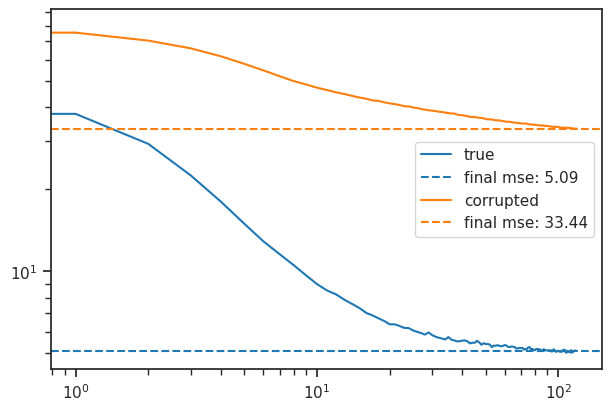

In [40]:
fig, ax = create_figure(1, 1, (6, 4))

x2p = tonp(output_true['loss_recon'].mean(0))
plt.loglog(x2p, label='true')
plt.axhline(x2p[-1], color='C0', ls='--', label=f"final mse: {x2p[-1]:0.2f}")

x2p = tonp(output_corrupted['loss_recon'].mean(0))
plt.loglog(x2p, label='corrupted')
plt.axhline(x2p[-1], color='C1', ls='--', label=f"final mse: {x2p[-1]:0.2f}")

plt.legend()
plt.show()

## 7 - Salf & Pepper

### iterative (mlp)

#### ```best_times = False```

In [8]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='salt_pepper',
    corruption_kws={'amount': 0.3},
    t_recon=300,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=False, **kws)

100%|█████████████████████████████████████████| 300/300 [05:40<00:00,  1.14s/it]


In [12]:
results_vld['props']

{'t_recon': 300,
 't_halluc': None,
 'hallucinate': False,
 'amount': 0.3,
 'salt_vs_pepper': 0.5}

In [13]:
accuracy, results_vld['mse'].mean()

(0.847, 20.158388)

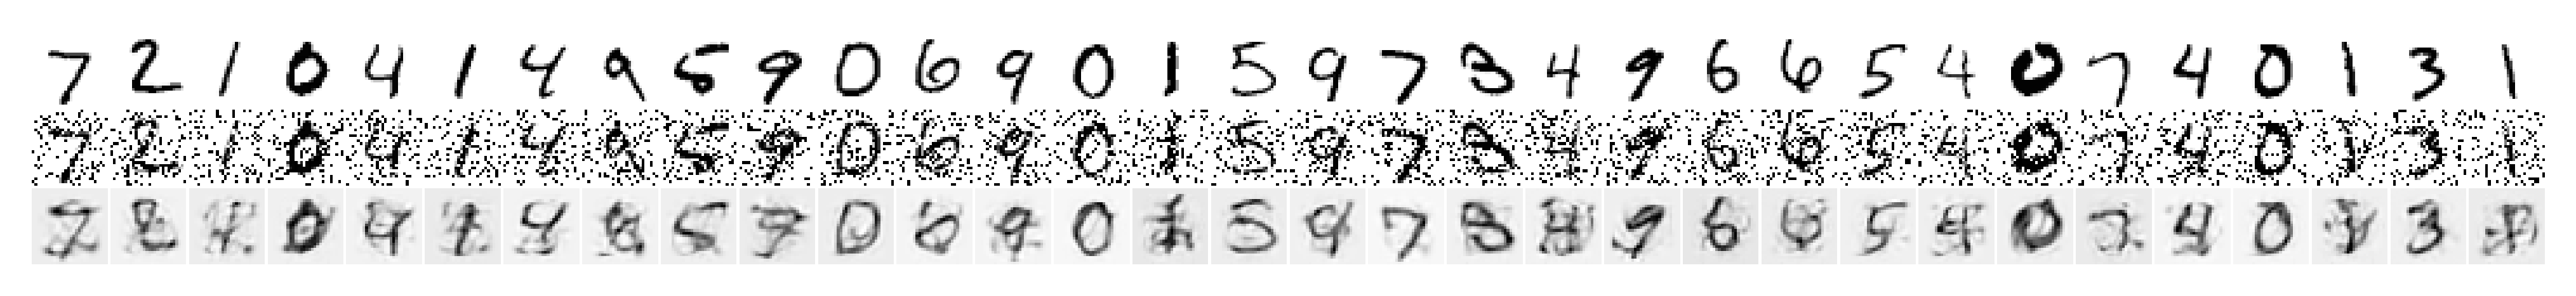

In [14]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

#### ```best_times = True```

In [15]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='salt_pepper',
    corruption_kws={'amount': 0.3},
    t_recon=300,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|█████████████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]


In [16]:
results_vld['props']

{'t_recon': 300,
 't_halluc': None,
 'hallucinate': False,
 'amount': 0.3,
 'salt_vs_pepper': 0.5}

In [17]:
accuracy, results_vld['mse'].mean()

(0.8745, 11.293656)

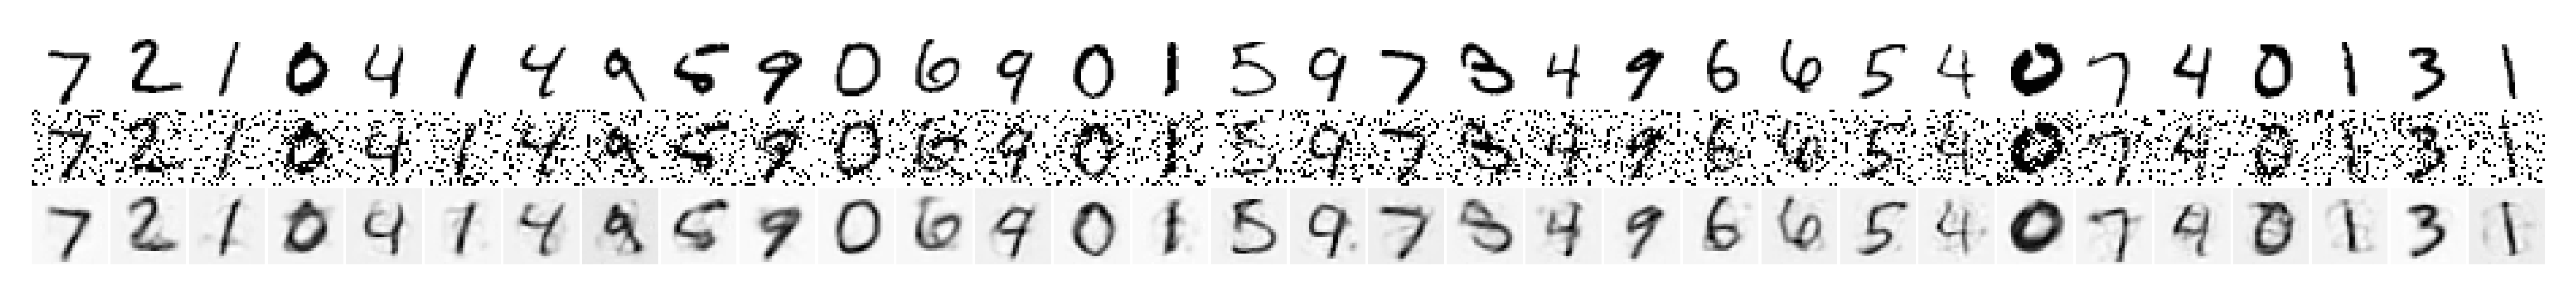

In [18]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### amortized (mlp)

In [19]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(**kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 164.58it/s]


In [20]:
results_vld['props']

{'t_recon': 1,
 't_halluc': None,
 'hallucinate': False,
 'amount': 0.3,
 'salt_vs_pepper': 0.5}

In [21]:
accuracy, results_vld['mse'].mean()

(0.8859, 39.25312)

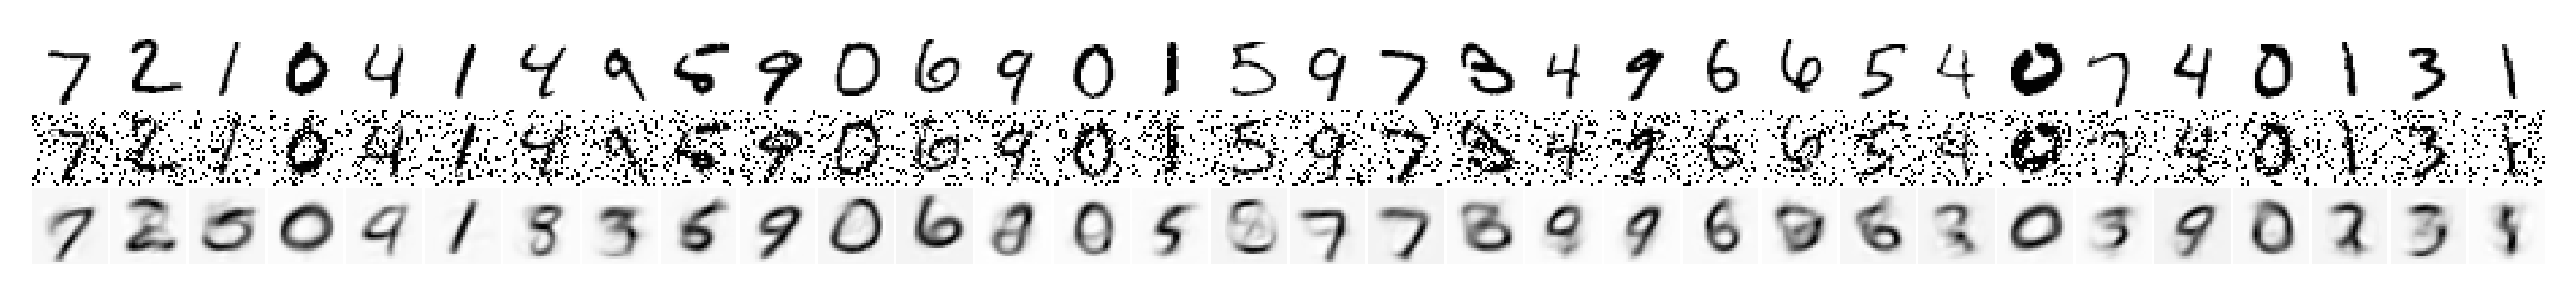

In [22]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

## 8 - Mask

### iterative (mlp)

In [7]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='mask',
    corruption_kws={'value': 0.5},
    t_recon=500,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|█████████████████████████████████████████| 300/300 [09:39<00:00,  1.93s/it]


In [8]:
results_vld['props']

{'t_recon': 500,
 't_halluc': None,
 'hallucinate': False,
 'value': 0.5,
 'height_range': (0.2, 0.4),
 'width_range': (0.2, 0.4),
 'ensure_interesting': True,
 'contrast_threshold': 0.3}

In [9]:
accuracy, results_vld['mse'].mean()

(0.8818, 11.044576)

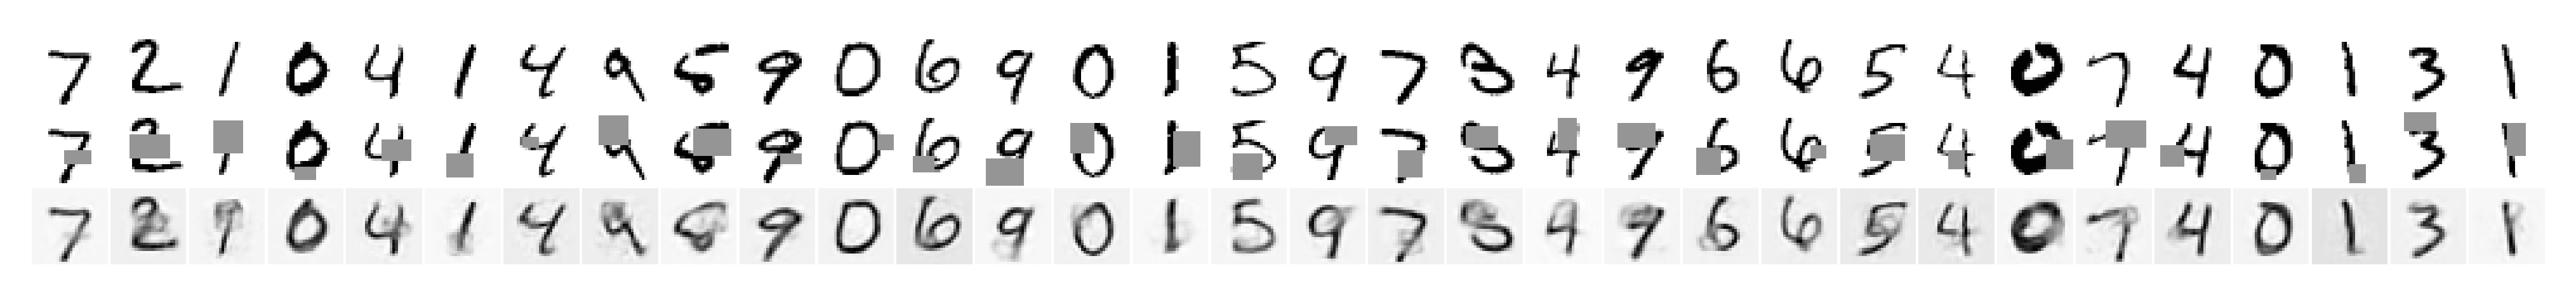

In [10]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### amortized (mlp)

In [11]:
kws['tr'] = trainers['amort-pois']
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 48.93it/s]


In [12]:
results_vld['props']

{'t_recon': 1,
 't_halluc': None,
 'hallucinate': False,
 'value': 0.5,
 'height_range': (0.2, 0.4),
 'width_range': (0.2, 0.4),
 'ensure_interesting': True,
 'contrast_threshold': 0.3}

In [13]:
accuracy, results_vld['mse'].mean()

(0.8615, 33.034527)

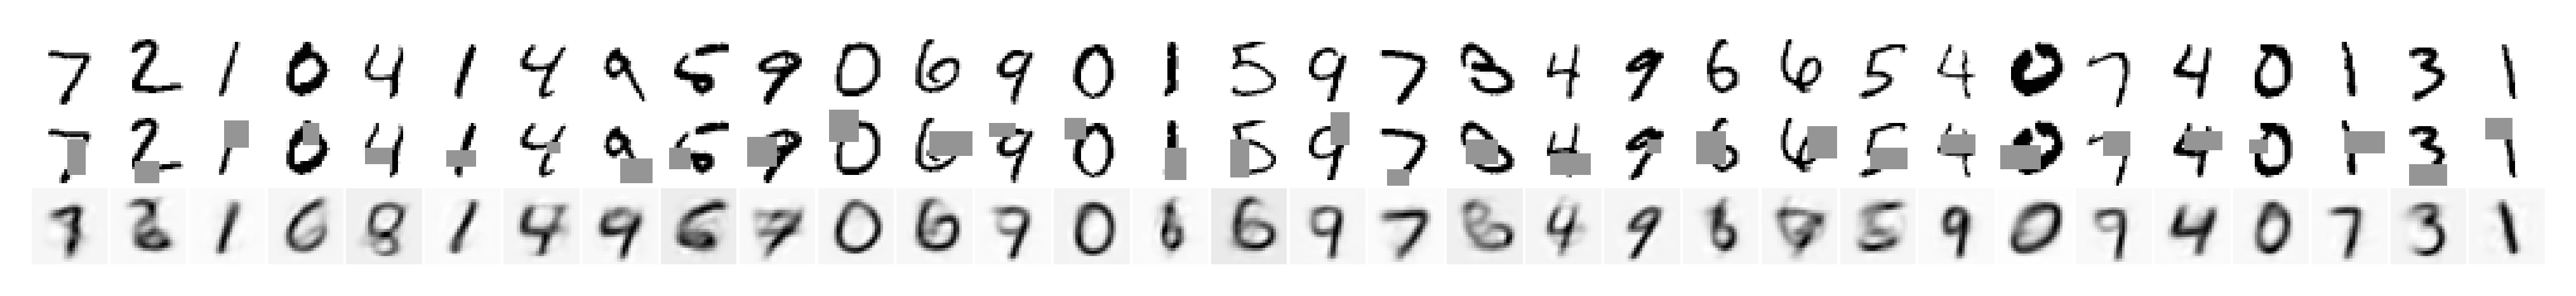

In [14]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

### iterative (mlp)
+ hallucinate
+ still best time points

In [22]:
kws = dict(
    tr=trainers['iter-pois'],
    corruption_type='mask',
    corruption_kws={'value': 0.5},
    t_recon=800,
    t_halluc=200,
    hallucinate=True,
    verbose=True,
)
results_trn, results_vld, accuracy = perform_corruption_analysis(
    best_times=True, **kws)

100%|█████████████████████████████████████████| 300/300 [21:58<00:00,  4.39s/it]


In [23]:
results_vld['props']

{'t_recon': 800,
 't_halluc': 200,
 'hallucinate': True,
 'value': 0.5,
 'height_range': (0.2, 0.4),
 'width_range': (0.2, 0.4),
 'ensure_interesting': True,
 'contrast_threshold': 0.3}

In [24]:
accuracy, results_vld['mse'].mean()

(0.8775, 10.555571)

In [9]:
## Was: w/o hallucination

(0.8818, 11.044576)

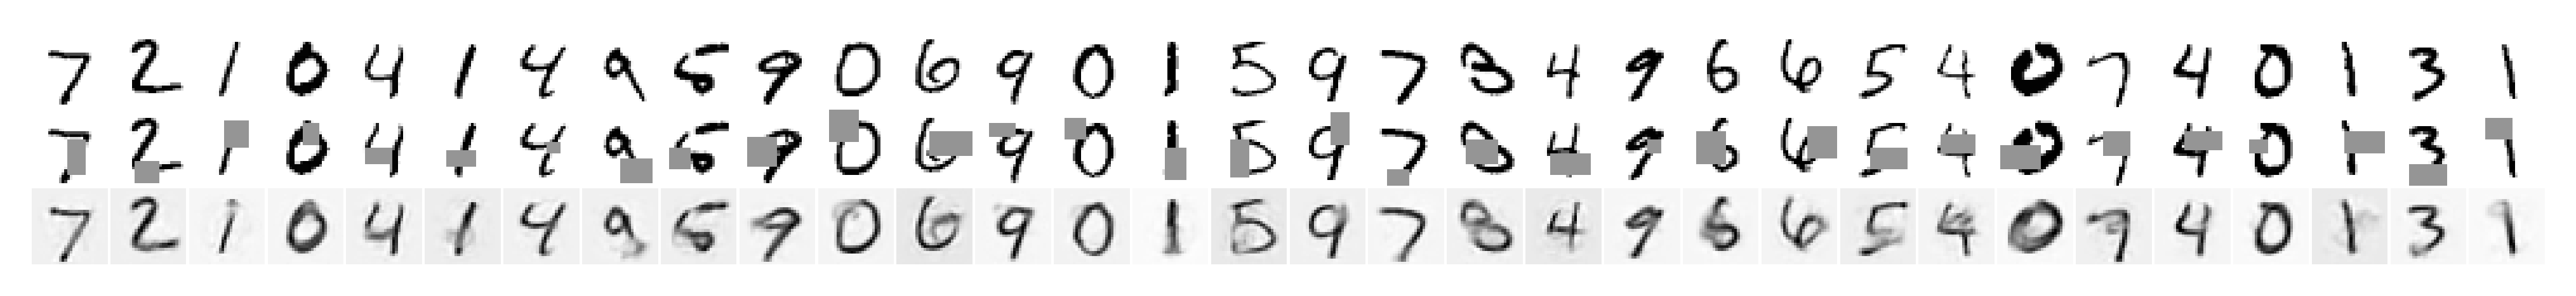

In [25]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    results_vld['x_corrupted'][:num].reshape(tr.model.cfg.shape),
    results_vld['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

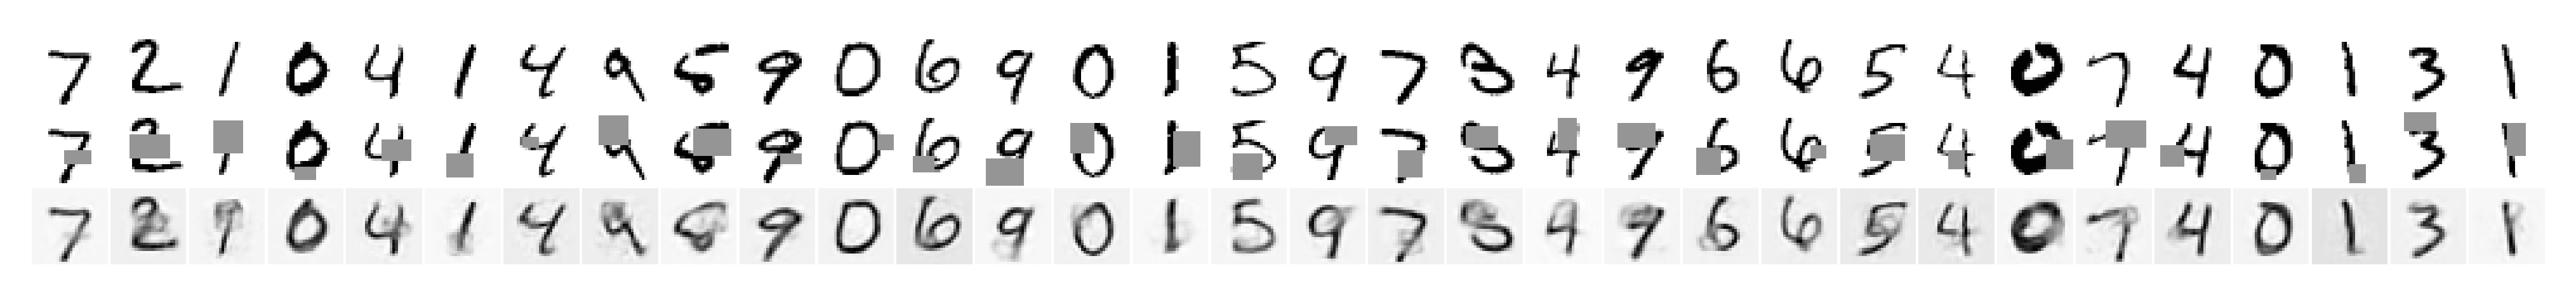

In [10]:
## Was: w/o hallucination

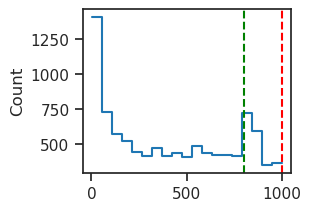

In [27]:
fig, ax = create_figure()
histplot(results_vld['selected_times'], ax=ax)
plt.axvline(
    results_vld['props']['t_recon'],
    color='g', ls='--')
plt.axvline(
    results_vld['props']['t_recon'] + results_vld['props']['t_halluc'],
    color='r', ls='--')